## <h2> Import Libraries </h2>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os import walk
from os.path import join

import nltk 
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split

%matplotlib inline

<h2> Constants </h2>

In [62]:
EXAMPLE_FILE = r'C:/Users/THE WIZRD/Desktop/SpamData/01_Processing/practice_email.txt'
SPAM_1_PATH = r'C:/Users/THE WIZRD/Desktop/SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = r'C:/Users/THE WIZRD/Desktop/SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = r'C:/Users/THE WIZRD/Desktop/SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = r'C:/Users/THE WIZRD/Desktop/SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'
DATA_JSON_FILE = r'C:/Users/THE WIZRD/Desktop/SpamData/01_Processing/spam_assassin_corpus/email-text-data.json'
WORD_ID_PATH = r'C:/Users/THE WIZRD/Desktop/SpamData/01_Processing/spam_assassin_corpus/word-id.csv'
TRAINING_DATA_FILE = r'C:/Users/THE WIZRD/Desktop/SpamData/02_Training/train_data.txt'
TESTING_DATA_FILE = r'C:/Users/THE WIZRD/Desktop/SpamData/02_Training/test_data.txt'

SPAM_CAT = 1
HAM_CAT = 0

VOCAB_SIZE = 2500

<h2> Reading Files </h2>

In [3]:
with open (EXAMPLE_FILE, mode='r', encoding='latin-1') as stream:
  stream = open(EXAMPLE_FILE)
  message = stream.read()

In [4]:
with open (EXAMPLE_FILE, mode='r', encoding='latin-1') as stream:
 is_body = False
 lines = []

 for line in stream:
  if is_body:
    lines.append(line)

  elif line == '\n':
    is_body = True

email_body = '\n'.join(lines)
print(email_body)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

<h2> Generator Functions </h2>


In [5]:
def email_body_generator(path):
  for root, dirnames, filenames in walk(path):
    for file_name in filenames:
      filepath = join(root, file_name)
      stream = open(filepath, encoding='latin-1')
      is_body = False
      lines = []

      for line in stream:
        if is_body:
          lines.append(line)

        elif line == '\n':
         is_body = True
      stream.close()
      email_body = '\n'.join(lines)
      yield file_name, email_body


In [6]:
def df_from_directory(path, classification):
  rows = []
  row_names = []

  for file_name, email_body, in email_body_generator(path):
    rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
    row_names.append(file_name)

  return pd.DataFrame(rows, index=row_names)

In [7]:
# Create the initial DataFrame from SPAM_1_PATH
spam_emails1 = df_from_directory(SPAM_1_PATH, SPAM_CAT)

# Create the second DataFrame from SPAM_2_PATH
spam_emails2 = df_from_directory(SPAM_2_PATH, SPAM_CAT)

# Concatenate the two DataFrames vertically
spam_emails = pd.concat([spam_emails1, spam_emails2], ignore_index=True)

spam_emails.shape

spam_emails.head()





,MESSAGE,CATEGORY
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
3,##############################################...,1
4,I thought you might like these:\n\n1) Slim Dow...,1


In [8]:
# Non spam Emails
# Create the initial DataFrame from SPAM_1_PATH
nonspam_emails1 = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)

# Create the second DataFrame from SPAM_2_PATH
nonspam_emails2 = df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT)

# Concatenate the two DataFrames vertically
nonspam_emails = pd.concat([nonspam_emails1, nonspam_emails2], ignore_index=True)

nonspam_emails.shape


(3901, 2)

In [9]:
data = pd.concat([spam_emails, nonspam_emails])
data.shape
data.head()

,MESSAGE,CATEGORY
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
3,##############################################...,1
4,I thought you might like these:\n\n1) Slim Dow...,1


## Data Cleaning: Checking for Missing Values

In [10]:
 # check if any message bodies are null
    
#data.MESSAGE.isna().value_counts()
#data.MESSAGE.duplicated().sum()


data.MESSAGE.isna().values.any()

False

In [11]:
my_var = None

In [12]:
#(data.MESSAGE.str.len() == 0).any()
(data.MESSAGE.str.len() == 0).sum()

3

## Locate Empty Emails

In [13]:
data[data.MESSAGE.str.len() == 0].index

Int64Index([500, 1897, 2500], dtype='int64')

In [14]:
data.drop([500,1897,2500], inplace=True)

In [15]:
data.shape

(5794, 2)

## Add Document Ids to Track Emails in Dataset


In [16]:
document_ids = range(0, len(data.index))
data['DOC_ID'] = document_ids
data = data.set_index('DOC_ID')
data.head()

,MESSAGE,CATEGORY
DOC_ID,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
3,##############################################...,1
4,I thought you might like these:\n\n1) Slim Dow...,1


## Save to File Using Pandas


In [17]:
data.to_json(DATA_JSON_FILE)

## Number of Spam Messages Visualised (Pie Charts)


In [18]:
data.CATEGORY.value_counts()
amount_of_spam = data.CATEGORY.value_counts()[0]
amount_of_ham = data.CATEGORY.value_counts()[1]
category_names = ['Spam', 'Legit Mail']
size = [amount_of_spam, amount_of_ham]


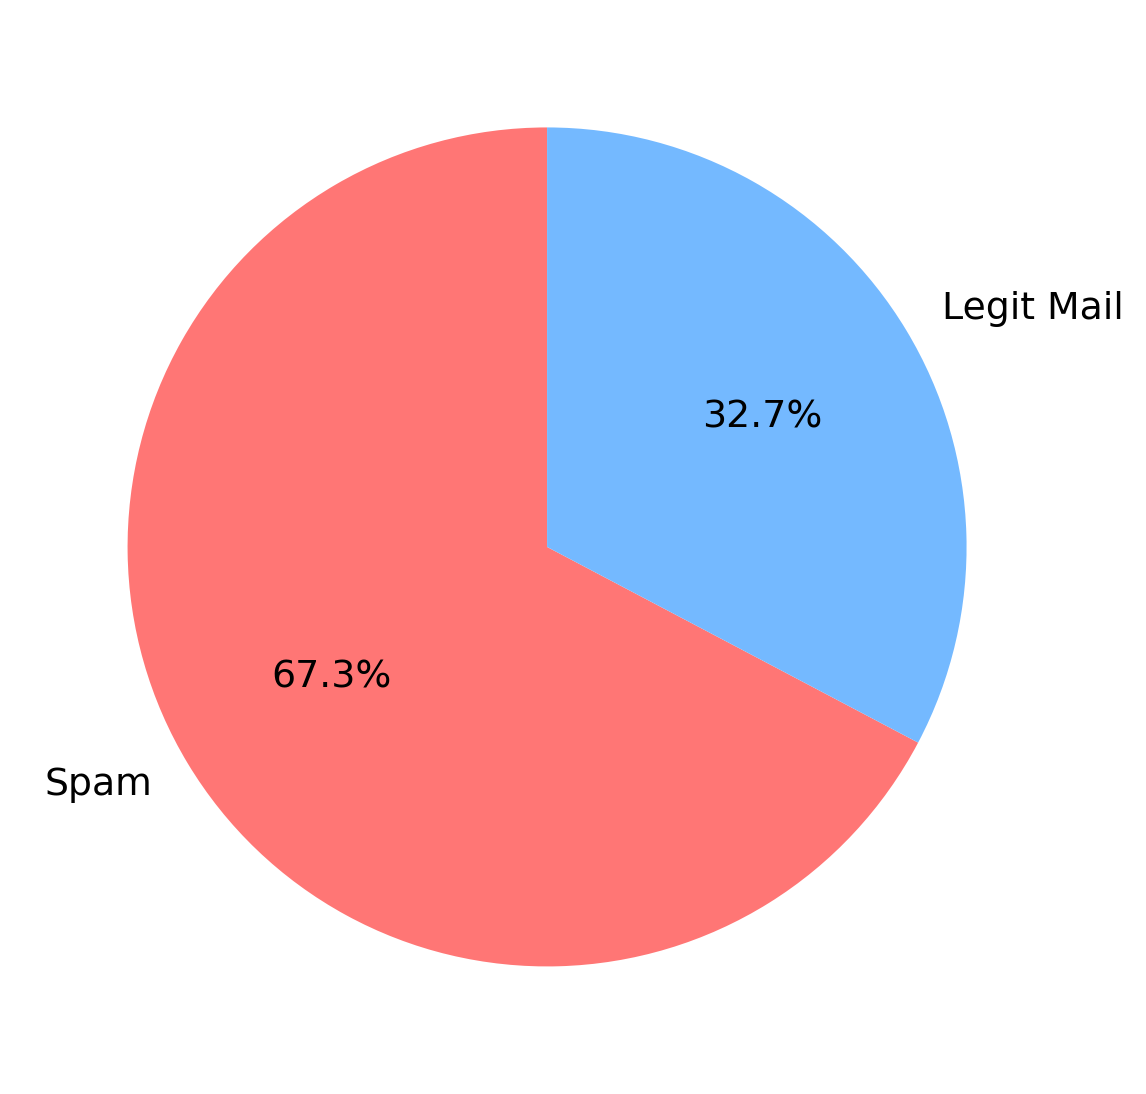

In [19]:
custom_colors = ['#ff7675', '#74b9ff']

plt.figure(figsize=(6,6), dpi=227)

plt.pie(size, labels=category_names, textprops={'fontsize': 12}, 
        startangle=90, autopct = '%1.1f%%', colors=custom_colors)


plt.show()

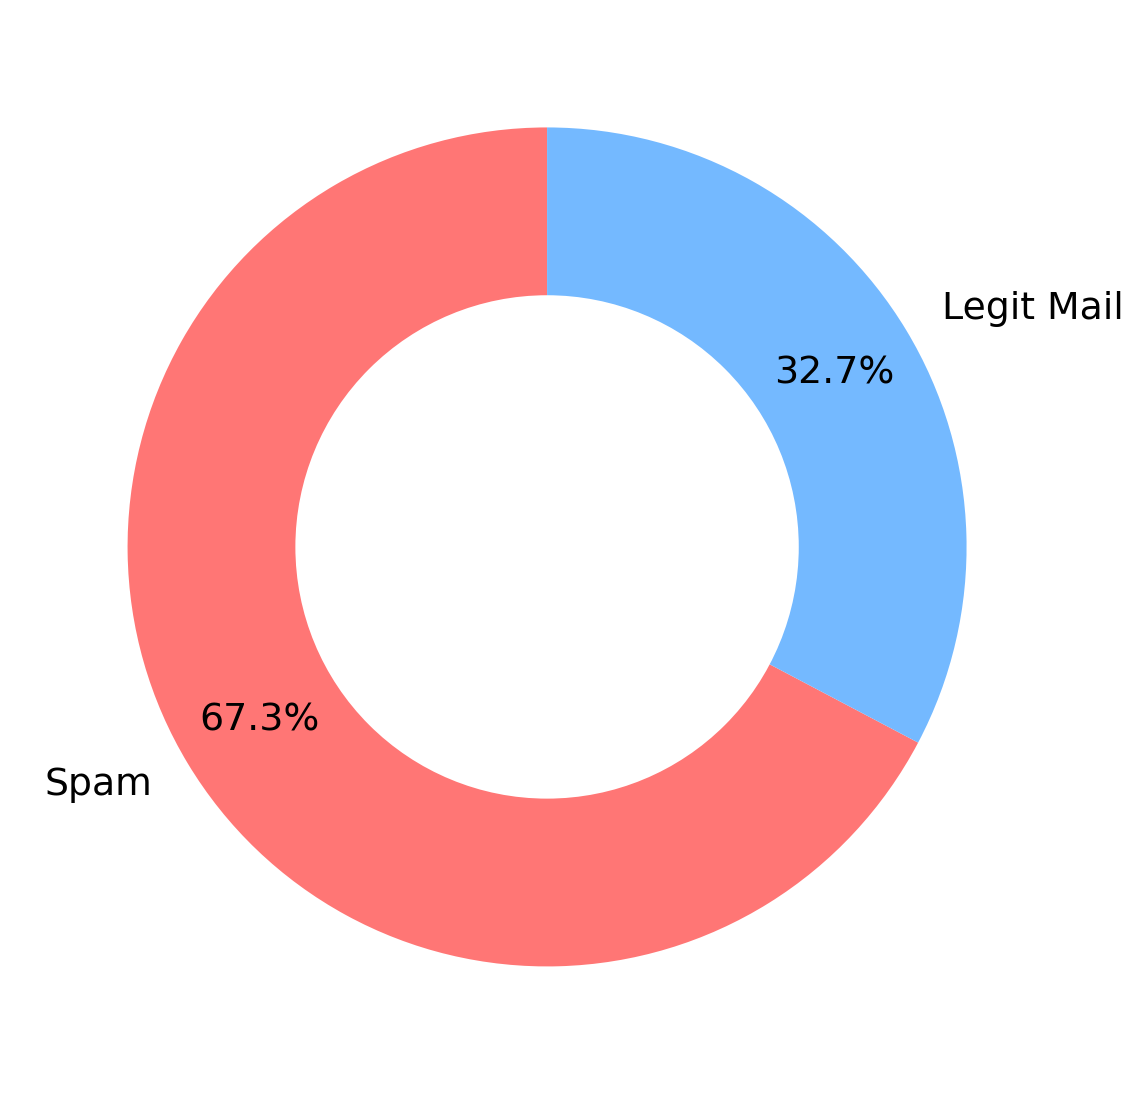

In [20]:
custom_colors = ['#ff7675', '#74b9ff']

plt.figure(figsize=(6,6), dpi=227)

plt.pie(size, labels=category_names, textprops={'fontsize': 12}, 
        startangle=90, autopct = '%1.1f%%', colors=custom_colors, pctdistance=0.8)

# draw circle

centre_circle = plt.Circle((0,0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)
plt.show()

# Natural Language Processing

## Text Pre-Processing

In [21]:
nltk.download('punkt')
nltk.download('gunterberg')
nltk.download('shakespeare')


[nltk_data] Downloading package punkt to C:\Users\THE
[nltk_data]     WIZRD\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Error loading gunterberg: Package 'gunterberg' not found
[nltk_data]     in index
[nltk_data] Downloading package shakespeare to C:\Users\THE
[nltk_data]     WIZRD\AppData\Roaming\nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!


True

### Tokenising

In [22]:
msg = 'Hello this is my first NLP work!! @@ '

token = set(word_tokenize(msg.lower()))


### Removing Stop Words

In [23]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\THE
[nltk_data]     WIZRD\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [24]:
stop_words = set(stopwords.words('english'))

In [25]:
msg = 'Hello this is my first NLP work!! @@, to be or not to be. '

words = set(word_tokenize(msg.lower()))

filtered_words = []
for word in words:
    if word not in stop_words:
        filtered_words.append(word)
        

print(filtered_words)

['work', 'first', ',', 'hello', '@', 'nlp', '!', '.']


## Word Stems and Stemming 

In [26]:
stemmer = PorterStemmer()

msg = 'Hello this is my first NLP work!! @@, to be or not to be. charging FASTInG  '

words = set(word_tokenize(msg.lower()))

filtered_words = []
for word in words:
    if word not in stop_words:
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)
        

print(filtered_words)

['work', 'first', 'charg', ',', 'hello', '@', 'nlp', '!', 'fast', '.']


## Removing Punctuation

In [27]:
'p'.isalpha()

True

In [28]:
stemmer = PorterStemmer()

msg = 'Hello this is my first NLP work!! @@, to be or not to be. charging FASTInG  '

words = set(word_tokenize(msg.lower()))

filtered_words = []
for word in words:
    if word not in stop_words and word.isalpha() == True:
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)
        

print(filtered_words)

['work', 'first', 'charg', 'hello', 'nlp', 'fast']


## Removing HTML tahgs from Emails

In [29]:
soup = BeautifulSoup(data.at[2,'MESSAGE'], 'html.parser')
print(soup.prettify())

1) Fight The Risk of Cancer!

http://www.adclick.ws/p.cfm?o=315&amp;s=pk007



2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days

http://www.adclick.ws/p.cfm?o=249&amp;s=pk007



3) Get the Child Support You Deserve - Free Legal Advice

http://www.adclick.ws/p.cfm?o=245&amp;s=pk002



4) Join the Web's Fastest Growing Singles Community

http://www.adclick.ws/p.cfm?o=259&amp;s=pk007



5) Start Your Private Photo Album Online!

http://www.adclick.ws/p.cfm?o=283&amp;s=pk007



Have a Wonderful Day,

Offer Manager

PrizeMama



























If you wish to leave this list please use the link below.

http://www.qves.com/trim/?zzzz@spamassassin.taint.org%7C17%7C308417



In [30]:
soup.get_text()

"1) Fight The Risk of Cancer!\n\nhttp://www.adclick.ws/p.cfm?o=315&s=pk007\n\n\n\n2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days\n\nhttp://www.adclick.ws/p.cfm?o=249&s=pk007\n\n\n\n3) Get the Child Support You Deserve - Free Legal Advice\n\nhttp://www.adclick.ws/p.cfm?o=245&s=pk002\n\n\n\n4) Join the Web's Fastest Growing Singles Community\n\nhttp://www.adclick.ws/p.cfm?o=259&s=pk007\n\n\n\n5) Start Your Private Photo Album Online!\n\nhttp://www.adclick.ws/p.cfm?o=283&s=pk007\n\n\n\nHave a Wonderful Day,\n\nOffer Manager\n\nPrizeMama\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nIf you wish to leave this list please use the link below.\n\nhttp://www.qves.com/trim/?zzzz@spamassassin.taint.org%7C17%7C308417\n\n\n"

## Fucntions for Email Processing


In [31]:
def clean_msg(message, stemmer=PorterStemmer(), 
                  stop_words=set(stopwords.words('english'))):
    
    # Remove Html tags from emails
    soup = BeautifulSoup(message, 'html.parser')
    cleaned_text = soup.get_text()
    
    # Convert to lower case and split up the words
    words = word_tokenize(cleaned_text.lower())
    filtered_words = []
    
   
    for word in words:
        # Removes the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    
    return filtered_words

   

In [32]:
clean_msg(data.at[2, 'MESSAGE'])

['fight',
 'risk',
 'cancer',
 'http',
 'slim',
 'guarante',
 'lose',
 'lb',
 'day',
 'http',
 'get',
 'child',
 'support',
 'deserv',
 'free',
 'legal',
 'advic',
 'http',
 'join',
 'web',
 'fastest',
 'grow',
 'singl',
 'commun',
 'http',
 'start',
 'privat',
 'photo',
 'album',
 'onlin',
 'http',
 'wonder',
 'day',
 'offer',
 'manag',
 'prizemama',
 'wish',
 'leav',
 'list',
 'pleas',
 'use',
 'link',
 'http',
 'zzzz']

## Apply CLeaning and Tokenisation to all messages

In [33]:
data['MESSAGE'] = data.MESSAGE.apply(clean_msg)



C:\Users\THE WIZRD\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
C:\Users\THE WIZRD\anaconda3\lib\site-packages\bs4\__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [34]:
data.MESSAGE


DOC_ID
0       [save, life, insur, spend, life, quot, save, g...
1       [fight, risk, cancer, http, slim, guarante, lo...
2       [fight, risk, cancer, http, slim, guarante, lo...
3       [adult, club, offer, free, membership, instant...
4       [thought, might, like, slim, guarante, lose, l...
                              ...                        
5789    [http, bizarr, collect, stuf, anim, could, fet...
5790    [care, use, one, also, realli, cute, thing, ja...
5791    [sm, skip, montanaro, write, jeremi, put, anot...
5792    [mark, hammond, like, given, zodb, sound, attr...
5793    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, Length: 5794, dtype: object

### Using Logic to Slice Dataframes

In [35]:
data.head()

,MESSAGE,CATEGORY
DOC_ID,,
0,"[save, life, insur, spend, life, quot, save, g...",1
1,"[fight, risk, cancer, http, slim, guarante, lo...",1
2,"[fight, risk, cancer, http, slim, guarante, lo...",1
3,"[adult, club, offer, free, membership, instant...",1
4,"[thought, might, like, slim, guarante, lose, l...",1


In [36]:
doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0].index



## Top 10 most common words in Ham & Spam Emails

In [37]:

nested_list_spam = data.loc[doc_ids_spam]
nested_list_ham = data.loc[doc_ids_ham]

nested_list_spam = nested_list_spam.MESSAGE.tolist()
nested_list_ham = nested_list_ham.MESSAGE.tolist()


spam_words = [item for sublist in nested_list_spam for item in sublist]


# Create nested lists for 'ham' category
ham_words = [item for sublist in nested_list_ham for item in sublist]





In [38]:
spam_words = pd.Series(spam_words)
ham_words = pd.Series(ham_words)


print(f'Top 10 words spam: \n{spam_words.value_counts()[:10]}\n')
print(f'Top 10 words non spam: \n{ham_words.value_counts()[:10]}\n')

print(f'Unique words spam: \n{spam_words.value_counts().shape[0]}\n')
print(f'Unique words non-spam: \n{ham_words.value_counts().shape[0]}\n')

Top 10 words spam: 
http      3097
email     3090
free      2585
click     2058
receiv    1989
list      1971
get       1914
pleas     1852
busi      1792
order     1746
dtype: int64

Top 10 words non spam: 
http      7557
use       3630
list      2880
one       2373
get       2286
mail      2255
would     2003
like      1931
messag    1849
work      1800
dtype: int64

Unique words spam: 
13241

Unique words non-spam: 
20812



## Creating a Word Cloud

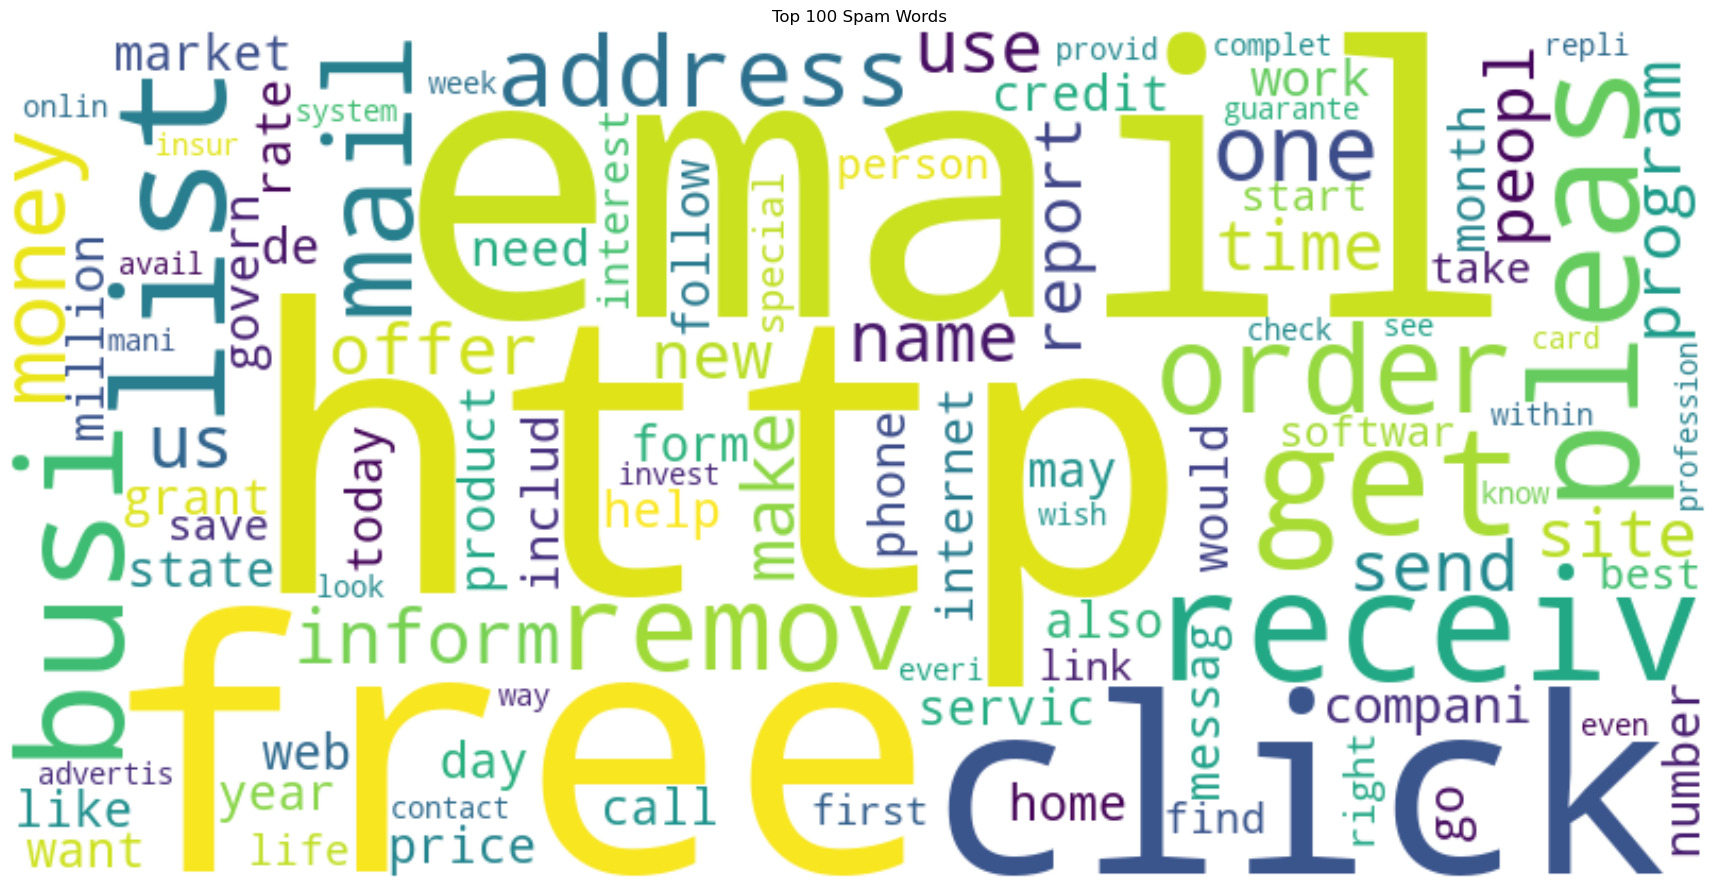

In [39]:
# Create a WordCloud for 'spam' words
spam_wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate_from_frequencies(spam_words.value_counts())

# Create a WordCloud for 'non-spam' words
ham_wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate_from_frequencies(ham_words.value_counts())

# Display the WordClouds using matplotlib
plt.figure(figsize=(18, 9))

plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.title('Top 100 Spam Words')
plt.axis('off')


plt.tight_layout()
plt.show()

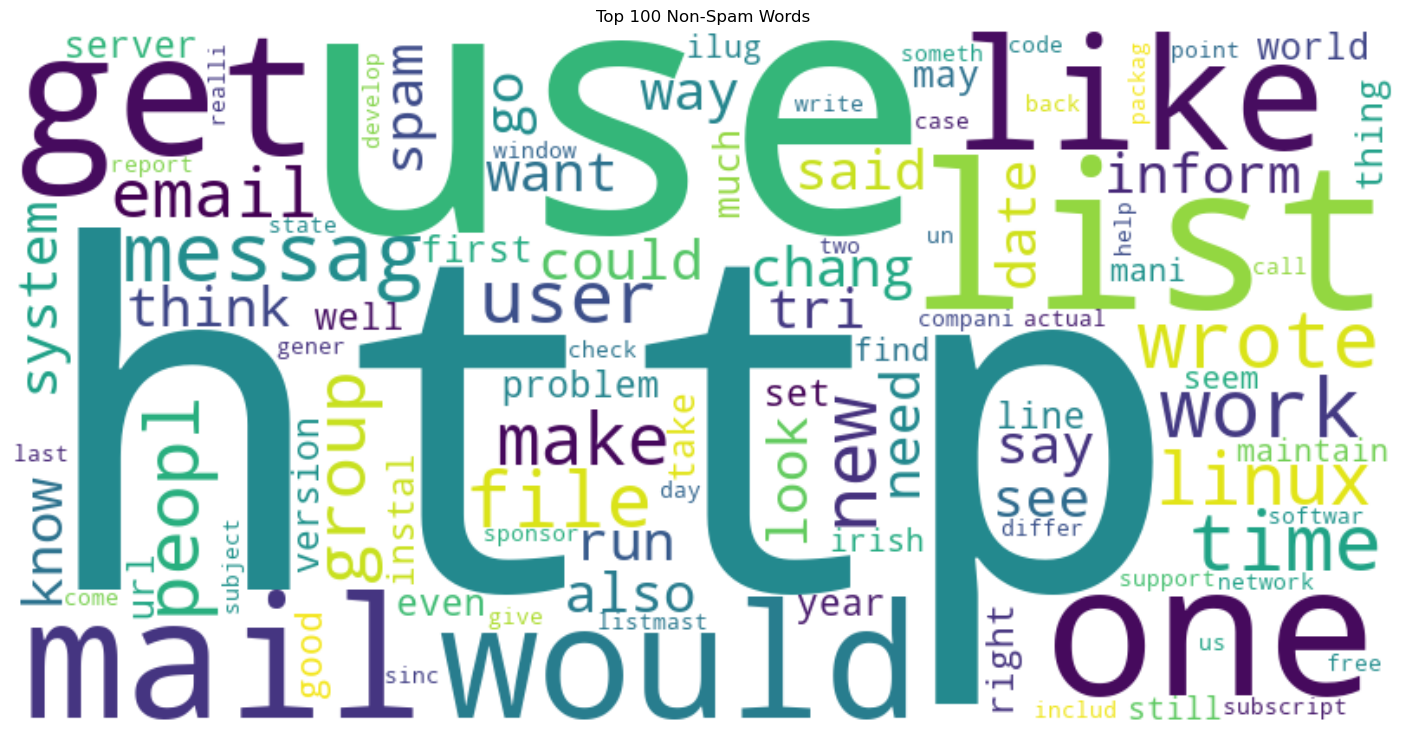

In [40]:
plt.figure(figsize=(18, 9))
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.title('Top 100 Non-Spam Words')
plt.axis('off')
plt.show()

In [41]:
flat_stemmed_list = spam_words.append(ham_words)


unique_words = flat_stemmed_list.value_counts()
unique_words.head()


frequent_words = unique_words[:VOCAB_SIZE]
frequent_words

C:\Users\THE WIZRD\AppData\Local\Temp\ipykernel_10188\3916444692.py:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  flat_stemmed_list = spam_words.append(ham_words)


http          10654
use            5016
list           4851
email          4367
get            4200
              ...  
apach            43
filesystem       43
strateg          43
corn             43
accid            43
Length: 2500, dtype: int64

In [42]:
## Create Vocabulary DataFrame with a WORD_ID

word_ids = list(range(0,2500))
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values}, index=word_ids)
vocab.index.name = 'WORD-ID'

## Save the Vocabulary as a CSV File

In [43]:
vocab.to_csv(WORD_ID_PATH, index_label = vocab.index.name, header=vocab.VOCAB_WORD.name)

## Generate Features & a  Sparse Matrix

In [44]:
stemmed_nested_list = data.MESSAGE
stemmed_nested_list = [words for words in stemmed_nested_list]


word_columns_df = pd.DataFrame.from_records(stemmed_nested_list)
word_columns_df.head()


,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,save,life,insur,spend,life,quot,save,g,famili,financi,...,None,None,None,None,None,None,None,None,None,None
1,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
2,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
3,adult,club,offer,free,membership,instant,access,site,user,name,...,None,None,None,None,None,None,None,None,None,None
4,thought,might,like,slim,guarante,lose,lb,day,http,fight,...,None,None,None,None,None,None,None,None,None,None


In [45]:
word_columns_df.shape

(5794, 7671)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(word_columns_df, data.CATEGORY, test_size=0.3, random_state=42)

In [47]:
print('Nr of training samples', X_train.shape[0])

Nr of training samples 4055


In [48]:
X_train.index.name = X_test.index.name = 'DOC_ID'
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
368,tremend,save,toner,inkjet,fax,thermal,replenish,toner,go,secret,...,None,None,None,None,None,None,None,None,None,None
3276,danq,think,would,make,sens,start,habea,less,danq,aggress,...,None,None,None,None,None,None,None,None,None,None
1151,herbal,altern,erectil,dysfunct,men,iron,featur,tv,news,top,...,None,None,None,None,None,None,None,None,None,None
2705,http,gab,thought,nekkid,url,go,gab,infring,amend,right,...,None,None,None,None,None,None,None,None,None,None
3260,hi,tri,build,sa,digit,unix,receiv,compil,error,mani,...,None,None,None,None,None,None,None,None,None,None


### Create a sparse Matrix for the Training Data

In [49]:
word_index = pd.Index(vocab.VOCAB_WORD)

In [50]:
def make_sparse_matrix(df,indexed_words, labels):
    '''
    Returns sparse matrix as dataframe.
    
    df: A df with words in the columns with a document id as an index(X_train or X_test)
    labels: category as a series (y_train, y_test)
    '''
    
    nr_rows=df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_cols):
            
            word = df.iat[i,j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                
                item = {'LABEL': category, 'DOC_ID': doc_id,
                       'OCCURENCE': 1, 'WORD_ID': word_id}
                
                dict_list.append(item)
                
                
    return pd.DataFrame(dict_list)
            
            
    

In [52]:
%%time
sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)

Wall time: 11min 46s


In [53]:
sparse_train_df

,LABEL,DOC_ID,OCCURENCE,WORD_ID
0,1,368,1,2218
1,1,368,1,138
2,1,368,1,621
3,1,368,1,2119
4,1,368,1,276
...,...,...,...,...
426006,1,860,1,47
426007,1,860,1,1430
426008,1,860,1,26
426009,1,860,1,21


### Combine Occurrences with the pandas

In [54]:
train_grouped = sparse_train_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
train_grouped = train_grouped.reset_index()
train_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,0,2,1,1
1,0,3,1,2
2,0,4,1,1
3,0,7,1,3
4,0,11,1,1


In [55]:
train_grouped.shape

(257834, 4)

### Save Training Data as .txt File

In [58]:
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt = '%d')

In [61]:
%%time
sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)


Wall time: 5min 15s


In [63]:
test_grouped = sparse_test_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
test_grouped = test_grouped.reset_index()
test_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,8,2,1,1
1,8,3,1,4
2,8,4,1,2
3,8,5,1,1
4,8,6,1,2


In [64]:
np.savetxt(TESTING_DATA_FILE, train_grouped, fmt = '%d')